# Phys 581 Winter 2019
# Final Project: Computational methods in quantum many-body physics
## Alexander Hickey, 10169582

Note that the contents of this notebook were created and tested in a 64-bit distribution of Windows 10, using Python 3.6.8.

In [1]:
import sys
sys.version

'3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]'

In [2]:
#Import useful libraries
from multiprocessing import Pool
import numpy as np
import psutil
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

Over the past two-decades, the increasing computational power available to researchers has lead to significant advances in the area of quantum many-body physics. Numerical methods continue to play an increasingly prominent role in this field. Despite these advances, simulating many-body systems remains a difficult task, as the underlying Hilbert space scales exponentially with the number of particles. To get around this, various analytical and numerical techniques have been explored to approximate solutions of these types of problems.

Recently, there has been immense experimental advances in the trapping of ultracold atoms in optical lattices (atomic lattices constructed by interfering lasers), which has renewed interest in lattice models of neutral bosonic atoms [1-2]. Such environments serve as ideal playgrounds to study the dynamics of quantum many-body systems, as experimentalists have precise control of the underlying lattice potential, and the properties of ultracold atoms can be widely tuned with external fields. In particular, the versatility of optical lattice environments has lead to the realization of a wide range of quantum phase transitions, which refers to phase transitions that occur only at low temperatures, where thermal fluctuations are strongly suppressed. 

The canonical example of such a model is the Bose-Hubbard model, which describes an approximate Hamiltonian for atoms in an optical lattice, and consists of bosons hopping between discrete lattice sites, and interacting at close range. It has been shown that in such a model, the competing lattice tunnelling and interaction terms drive a quantum phase transition between superfluid and insulating phases. Since then, the Bose-Hubbard model has been realized experimentally, and extensions to the model have been of great interest from both the experiment and theory point of view.

The main difficulty that arises in the theoretical study of the Bose-Hubbard model is that the Hamiltonian cannot be diagonalized analytically whenever interactions are present. Additionally, numerical studies are restricted by the exponential scaling of the lattice. The latter problem role is generally supressed by a studying the model within a mean-field theory, where long range correlations are approximated to first order by replacing some operators by their average values.

This notebook presents the explorations of various computational methods that can be used to study the Bose-Hubbard model in the context of a zero-temperature mean-field theory. In particular, we will explore the method of exact diagonalization, variational methods, as well as imaginary-time propagation to compute ground states in the Bose-Hubbard model for various parameters. The benchmarks used to compare each method will be ability of the method to produce a mean-field phase diagram that is consistent with current literature, as well as the time required to perform such a task.



## Background

### Bosons

There are many systems in nature that are comprised of several identical particles. Such particles all share the same intrinsic properties, such as charge, mass and spin, and therefore cannot be distinguished by measuring their underlying characteristics. In classical mechanics, these particles can be readily distinguished by following their individual trajectories through phase space. In quantum mechanics however, such a trajectory is ill-defined due to the Heisenberg uncertainty principle.

This principle of indistinguishibility turns out to be quite fundamental, as it implies that many identical quantum particles obey either Fermi or Bose statistics. Particles that obey the former are known as *fermions*, and they are characterized by obeying the Pauli exclusion principle, which states that no two particles can occupy the same quantum state. In contrast, particles that obey Bose statistics are known as *bosons*, and an arbitrary number of them can occupy the same state. In this work, we will consider only bosonic particles, which is motivated by the fact that the aforementioned optical lattice experiments are often performed with neutral bosonic atoms, most notably with $^{87}\text{Rb}$, which was used to create the first Bose-Einstein condensate in 1995.

Since the particles are indistinguishable, we don't care about which particle is where, but rather just how many bosons are occupying each available quantum state. In our case, these so called states will correspond to a particles position on a 1D lattice. A convenient choice of an orthonormal basis for representing a many-body bosonic wavefunction is therefore the *occupation number basis*, where the basis vectors look like 

$$| n_0 ,n_1,n_2,\ldots \rangle$$

which corresponds to the state with $n_0$ bosons occupying the $0^\text{th}$ lattice site, $n_1$ bosons occupying the $1^\text{st}$ lattice site, and so on. Any arbitrary many-body wavefunction can then be written as a superposition of vectors in the occupation number basis. 

We would now like to be able to describe operators in this representation. To each lattice site, we associate a pair of operators $\hat a_j^\dagger$ and $\hat a_j$, known as creation and annihilation operators, which obey the commutator relations

$$[ \hat a_j ;  \hat a_k] = 0  \qquad [ \hat a_j, \hat a_k^\dagger] = \delta_{jk}$$

In particular, the action of these operators on an occupation number basis state is given by

\begin{align}
\hat a_j | n_0,n_1, \ldots,n_j ,\ldots \rangle &= \sqrt{n_j} | n_0,n_1, \ldots,n_j-1 ,\ldots \rangle \\
\hat a_j^\dagger | n_0,n_1, \ldots,n_j ,\ldots \rangle &= \sqrt{n_j+1} | n_0,n_1, \ldots,n_j +1,\ldots \rangle .
\end{align}

That is, the action of a creation (annihilation) operator is to quite literally create (annihilate) a boson that is occupying the $j^\text{th}$ state. It is also convenient to define a number operator

$$ \hat n_j  =  \hat a_j^\dagger \hat a_j $$

where the action of the number operator is to count the number of bosons occupying the $j^\text{th}$ lattice site, i.e.

$$\hat n_j | n_0,n_1, \ldots,n_j ,\ldots \rangle = n_j  | n_0,n_1, \ldots,n_j ,\ldots \rangle .$$

### The Bose-Hubbard model

Next, I will formally introduce the Bose-Hubbard model, which serves as an approximate model for bosons in an optical lattice environment.

An optical lattice is a periodic potential created by interfering laser light. If an atom occupies this lattice, it will have some probability of tunnelling to a different lattice site, with the probability depending on the geometry of the underlying potential. In this work, we will consider only bosonic atoms, which in principle is any atom with an even total number of constituent electrons, protons and neutrons. Such atoms obey bosonic statistics, meaning that an arbitrary number of atoms can share the same quantum state.

THe Bose-Hubbard model simplifies the dynamics of atoms confined to an optical lattice by discretizing each potential well to a specific lattice site, which either contains atoms or doesn't. The model describes these bosons tunnelling between nearest-neighbour lattice sites, as well as a repulsive interaction between bosons on the same lattice site. The Hamiltonian for this model is 

\begin{equation}  
\hat H = -t \sum_{\langle j,k \rangle} \hat a_{j}^\dagger \hat a_{k} + \frac U2 \sum_{j} \hat n_{j} \left( \hat n_{j} -1 \right) -\mu \sum_{j} \hat n_{j}
\end{equation}

where $\langle j,k \rangle$ indicates the sum be taken over nearest neighbours, $\hat a_j^\dagger$ and $\hat a_j$ are the bosonic creation and annihilation operators acting on the $j^\text{th}$ lattice site, and $\hat n_j = \hat a_j^\dagger \hat a_j$ is the number operator. In particular, this means that the action of the $\hat a_j^\dagger$ $\left( \hat a_j \right)$ is to create (remove) a boson from the $j^\text{th}$ site of the lattice, and the action of the $\hat n_j$ operator is to count the number of bosons on this site. The first term in the Hamiltonian corresponds to nearest-neighbour tunnelling between sites (see Fig. 1), and the energy $t$ is known as the \textit{tunnelling amplitude}, which is a measure of how likely a boson is to hop to a neighbouring site. This term favours the delocalization of bosons across the lattice whenever $t >0$. The second term models an on-site repulsive force, by counting the $\binom{n_j}{2} = \frac 12 n_j(n_j-1)$ mutual interactions of energy $U$ between bosons on the $j^\text{th}$ site. The last term in the Hamiltonian is the chemical potential, which fixes the average particle number in the grand canonical ensemble.



![Hopping on a lattice](lattice.png)

Fig. 1. Hopping on a 1D lattice. The operator $\hat a_{j-1}$ deletes a boson on site $j-1$, and the operator $\hat a_j^\dagger$ creates a boson on site $j$. The action of the operator $\hat a_j^\dagger \hat a_{j-1}$ therefore corrsponds to a boson hopping to the right, and its adjoint represents a boson hopping to the left. Figure made in TikZ.


### Mean field theory

As mentioned previously, the main problem that arises in numerical studies of the Bose-Hubbard model is the exponential scaling of the Hilbert space with the number of lattice sites. The typical way to make the problem more feasible for numerical simulations is to decouple the lattice sites from one another, by employing a mean field theory.

To do this, we will look specifically at the operators in the Hamiltonian that involve products of operators acting on different lattice sites. These operators take the form $\hat a_{j}^\dagger \hat a_{k}$ where $j,k$ correspond to indices of neighbouring lattice sites. We can define a set of "fluctuation operators"

\begin{equation}
\delta \hat a_{j} \equiv \hat a_{j} - \psi_j
\end{equation}

where $\psi_j \equiv \langle \hat a_{j} \rangle$ is the expectation value of $\hat a_j$ in the ground state. It follows that $\langle \delta \hat a_j \rangle \approx 0$ for states that are close to the true ground state. We can then rewrite the products of operators acting on different sites as:

\begin{align*}
\hat a_{j}^\dagger \hat a_{k} &= \Big( \delta \hat a_{j }^\dagger +\psi_j^* \Big)  \Big( \delta \hat a_{k } +\psi_k \Big)  \\
&= \delta \hat a_{j}^\dagger \delta \hat a_{k} +  \psi_j^*  \delta \hat a_{k } + \delta \hat a_{j}^\dagger \psi_k + \psi_{j}^* \psi_k . \\
\end{align*}

The mean field approximation is then to assume that correlations are small enough that we can ignore the term which is second order in the fluctuation operator. Under this assumption, the product becomes

\begin{align*} 
\hat a_{j}^\dagger \hat a_{k} &\approx \psi_j^*  \delta \hat a_{k } + \delta \hat a_{j}^\dagger \psi_k + \psi_{j}^* \psi_k \\
&=   \psi_j^*  \hat a_{k } +\hat a_{j}^\dagger \psi_k - \psi_{j}^* \psi_k 
\end{align*}

which is simply a sum of single site operators multiplied by a scalar expectation value. Next, we will assume that the lattice is effectively infinite in size, and is therefore translationally symmetric. Each lattice site will therefore look the same, and we can assume that $\psi_0 = \psi_1 = \cdots = \psi_N \equiv \psi$. With the aforementioned approximations, the Bose-Hubbard Hamiltonian becomes 

$$H = -t \sum_j  \left[ \psi^* \hat a_j + \psi \hat a_j^\dagger - |\psi|^2 \right] + \frac U2 \sum_{j} \hat n_{j} \left( \hat n_{j} -1 \right) -\mu \sum_{j} \hat n_{j}$$

This choice of mean field approximation effectively decouples operators acting on each site from one another, by replacing the operator with its average value. By decoupling the sites from one another, the system of interest will now scale linearly with the number of lattice sites, rather than exponentially, and is thus manageable for efficient numerical calculations.

The problem that remains is that we don't know the actual value of the mean-field parameter $\psi$. This can be obtained by assuming that the system is in equilibrium, and so the actual valus of $\psi$ will be the one that minimizes the free energy of the system. Furthermore, we are interested in the dynamics of this system at zero temperature, so the free energy corresponds to the total internal energy.

### Probing for phase transitions

The final question that remains is how we will actually probe for phase transitions in the model. Previous studies of this model have shown that the ground state exists in two distinct phases, namely, a Mott-insulator and a superfluid. It turns out that the expectation value $\psi = \langle a \rangle$ corresponds to the superfluid order parameter, meaning that an insulating phase corresponds to $\psi = 0$, and a superfluid phase corresponds to $\psi \neq 0$.

## Methods

### Exact diagonalization

The first method that will be explored is the method of exact diagonalization. We will start by explicitely constructing the Hamiltonian matrix, by computing the matrix elements of the Hamiltonian for a single site

$$\langle m | H | n \rangle = -t \psi^* \sqrt{n} \delta_{m,n-1} - t\psi \sqrt{n+1} \delta_{m,n+1} + \left(t |\psi|^2 + \frac{U}{2} n(n-1) - \mu n\right) \delta_{m,n}$$

for a given parameter set $(t,U,\mu)$. By dividing by the on-site interaction energy $U$, we make this Hamiltonian dimensionless, and effectively reduce the problem to two free parameters $\left( \frac{t}{U},\frac{\mu}{U} \right)$. Some arbitrary state is taken to be our initial guess, and the value of $\psi$ is computed accordingly. In principle, any number of bosons can occupy the lattice site, however, we truncate the Hilbert space to $N=10$ particles per site, so the wavefunction takes the form

$$| \phi_0 \rangle = \sum_{x=0}^N \beta_x | x \rangle $$

for some $\beta_0,\beta_1,\ldots,\beta_N$. The Hamiltonian matrix is then numerically diagonalized, and the state $| \phi_0 \rangle$ is then updated to be the lowest energy eigenvector of this Hamiltonian. The Hamiltonian matrix elements are then recomputed using the new state, and the process is repeated until a self-consistent value of the order parameter $\psi$ is obtained. The phase of the ground state is then inferred using the value of $\psi$. The set of tools used for exact diagonalization can be found in the appendix, or in the attached exact_diag.py module.

We will begin by analyzing how the energy behaves as a function of the order parameter. What we expect is that the order parameter is zero in the low-hopping limit $t/U \ll 1$, corresponding to an insulating phase, and at some critical hopping amplitude, there should be an insulator-superfluid transition, where $\psi$ becomes nonzero. The following plot shows how the ground state energy depends on the value of the order parameter, for varous choices in the hopping amplitude.

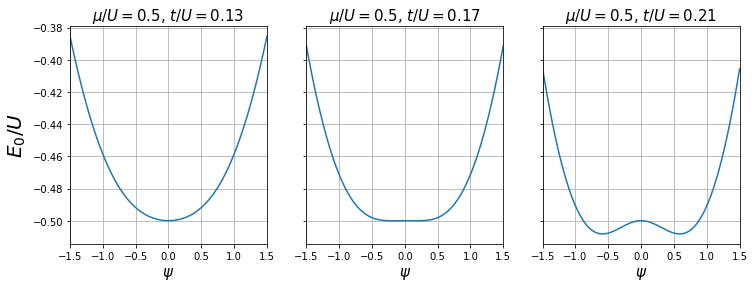

In [3]:
#Import module I wrote for exact diagonalization calculations
import exact_diag

#Set system parameters
mu = 0.5
t = [0.13,0.17,0.21]

#Iterate through possible order parameters
psi = np.linspace(-1.5,1.5,300)

#Array to record energies
E0 = np.zeros((len(t),len(psi)))

#Create figure
fig, ax = plt.subplots(1,len(t),figsize=(4*len(t),4),sharey = True)
ax[0].set_ylabel('$E_0/U$',fontsize = 20)

for j in range(len(t)):
    
    for k in range(len(psi)):
        
        #Compute ground state energy for given parameter set
        H = exact_diag.construct_hamiltonian(psi[k],t[j],mu)
        energy, state = exact_diag.groundstate(H)
        
        #Record energy
        E0[j][k] = energy
    
    #Plot results
    ax[j].plot(psi,E0[j])
    ax[j].set_xlim(np.min(psi),np.max(psi))
    ax[j].set_xlabel('$\psi$',fontsize = 15)
    ax[j].set_title('$\mu/U = ${}, $t/U = ${}'.format(mu,t[j]),fontsize = 15)
    ax[j].grid()
    
plt.show()

As expected, the free energy, which in this zero-temperature system corresponds to the ground state energy, is minimized by $\psi = 0$ for small values of the hopping amplitude. As the hopping amplitude increases past some critical value, two distinct minima in the free energy form, and so the ground state energy will correspond to a non-zero value of the order parameter. Note that this diagram reveals a symmetry in the Hamiltonian, as replacing $\psi$ with $-\psi$ leads to the same ground state energy. This breaking of symmetry when the ground state spontaneously chooses a value of $\psi$ is indicative of a continuous phase transition. To see this more clearly, we can look at how the order parameter depends on the hopping amplitude directly.

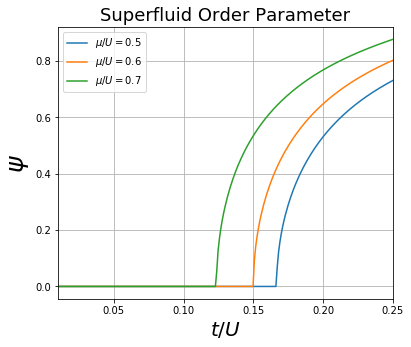

In [4]:
#Set system parameters
mulist = [0.5,0.6,0.7]
tlist = np.linspace(0.01,0.25,250)

#Array to records values of psi
psilist = np.zeros((len(tlist)))

#Create figure
plt.figure(figsize=(6,5))

#Iterate through system parameters
for j in range(len(mulist)):
    for k in range(len(tlist)):
        
        #Compute psi using exact diagonalization
        psilist[k] = exact_diag.find_psi(tlist[k],mulist[j])
    
    #Plot result
    plt.plot(tlist,psilist,label ='$\mu/U= ${}'.format(mulist[j]))

plt.title('Superfluid Order Parameter',fontsize = 18)
plt.xlim(np.min(tlist),np.max(tlist))
plt.xlabel('$t/U$',fontsize = 20)
plt.ylabel('$\psi$',fontsize = 25)
plt.legend()
plt.grid()
plt.show()

As expected, our results indicate that increasing the hopping amplitude triggers a continuous phase transition, characterized by a kink in the order parameter at a critical hopping amplitude. Finally, we can use this exact diagonalization to compute a phase diagram of the Bose-Hubbard model in the $\mu-t$ parameter space. Since computing the phase boundary requires many independent iterations through the parameter space, this makes the task ideal for parallelization. I will employ the multiprocessing Pool object to run the same number of tasks that I have processors in parallel.

In [10]:
#Count number of local CPUs
NCPU = psutil.cpu_count() 

#Define list of chemical potentials to search over
mulist = np.linspace(0.001,3.0,250)

#Need to include this if statement for some reason...
if __name__ == '__main__':        

    with Pool(NCPU) as p:
        
        #Compute boundary points using exact diagonalization
        bd = p.map(exact_diag.bd, mulist)


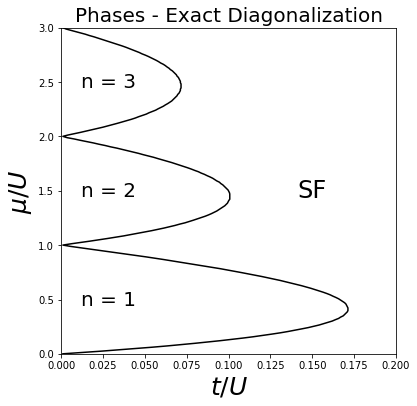

In [14]:
plt.figure(figsize=(6,6))
plt.plot(bd,mulist,color = 'black')
plt.title('Phases - Exact Diagonalization',fontsize = 20)
plt.xlabel('$t/U$',fontsize = 25)
plt.ylabel('$\mu /U$',fontsize = 25)
plt.xlim(0,0.2)
plt.ylim(np.min(mulist),np.max(mulist))

plt.text(0.15,3/2, 'SF', size=24, ha='center', va='center')
for n in range(1,4):
    plt.text(0.028, n-0.5, 'n = {}'.format(n), size=20, ha='center', va='center')

plt.show()

As we see, a very peculiar phase diagram arises. For low $t/U$, the ground state corresponds to a so-called Mott-insulator, and each of the "lobe" like regions correspond to insulators with different on-site densities, i.e. 1 particle per lattice site in the bottom lobe, 2 particles per site in the next one, and so on. For a large enough hopping amplitude, there is a phase transition and the ground state becomes a superfluid, characterized by a nonzero value of $\psi$. It is interesting how as the on-site density increases, the lobes become shorter, so the system requires a lower hopping amplitude to transition to a superfluid.

This phase diagram is consistent with previous studies of the Bose-Hubbard model, such as Ref. *** .

### Variational principle

Next we will analyze the Bose-Hubbard phase diagram in the context of the variational principle. The variational principle is an extraordinarily powerful technique that relies on a simple fact: the true ground state of a system is the one that minimizes the expectation value of the Hamiltonian $\langle \hat H \rangle$. The proof of this is relatively straightforward. Consider some system whose time evolution is governed by the Hamiltonian operator $\hat H$. Let $E_0 \leq  E_1 \leq E_2 \leq \cdots$ be the ordered list of energy eigenvalues, and $\{ | E_n \rangle \}$ the set of orthonormal energy eigenstates. Any normalized wavefunction can then be expanded as a superposition of energy eigenstates

\begin{equation*}
| \Psi(t) \rangle = \sum_n c_n e^{-i E_n t} | E_n \rangle
\end{equation*}

for some collection of complex numbers $\{c_n\}$ such that $\sum_n |c_n|^2 =1 $. It then follows that

\begin{align*}
\langle \Psi | \hat H  |\Psi \rangle= \sum_{mn} c_m^* c_n \langle \phi_m | \hat H | \phi_n \rangle =\sum_{mn} c_m^* c_n E_n  \langle  \phi_m | \phi_n \rangle  = \sum_n |c_n|^2 E_n \geq  \sum_n |c_n|^2 E_0 = E_0
\end{align*} 

where the inequality comes from the fact that $E_n \geq E_0$ for all $n$. By minimizing the function $\langle \hat H \rangle$ with respect to all possible wavefunctions $ | \psi \rangle$, we are therefore guaranteed to obtain a ground state. In cases where the ground state is degenerate, one can construct the eigenspace corresponding to the eigenvalue $E_0$ by repeating the minimization procedure for different trial wavefunctions.

In the case of the Bose-Hubbard model, the mean field Hamiltonian for a single site is given by

\begin{equation*}
\hat H = - t \left( \psi^* \hat a + \psi \hat a^\dagger - |\psi|^2 \right) + \frac{U}{2}  \hat n (\hat n-1) -\mu \hat n.
\end{equation*}

The expectation value is therefore given by

\begin{equation}
\langle \hat H \rangle = -t |\psi|^2 + \frac{U}{2} \langle \hat n (\hat n-1) \rangle - \mu \langle \hat n \rangle.
\end{equation}

We will use a trial wavefunction of the form

\begin{equation*}
| \phi_0 \rangle = \sum_{x=0}^N \beta_x | x \rangle
\end{equation*}

where we have truncated the Hilbert space, so that the maximum number of bosons on a site is $N=10$. We can assume that the expansion coefficients of the trial wavefunction are real, as the Hamiltonian matrix in the occupation number basis is real. It follows that 

\begin{align*}
\psi  = \langle \phi_0 | \hat a | \phi_0 \rangle &= \sum_{x,y=0}^N  \beta_x \beta_y \langle x | \hat a | y \rangle \\
&= \sum_{x,y=0}^N \beta_x \beta_y \sqrt{y} \langle x | y-1 \rangle \\
&= \sum_{x,y=0}^N \beta_x \beta_y \sqrt{y} \delta_{x,y-1} \\
&=  \sum_{x=1}^{N} \beta_{x-1} \beta_{x} \sqrt{x}
\end{align*}
and
\begin{align*}
\langle \hat n \rangle &= \sum_{x,y=0}^N  \beta_x \beta_y \langle x | \hat n | y \rangle =  \sum_{x,y=0}^N  \beta_x \beta_y  y  \langle x | y \rangle = \sum_{x=1}^N \beta_x^2 x  \\
\langle \hat n (\hat n-1) \rangle &= \sum_{x,y=0}^N  \beta_x \beta_y \langle x| \hat n (\hat n-1) | y \rangle = \sum_{x=1}^N \beta_x^2 x(x-1).
\end{align*}

Plugging these into the expectation value, and dividing by $\langle \phi_0 | \phi_0 \rangle = \sum_{x=0}^N \beta_x^2$ to ensure that the resulting wavefunction remains normalized, we get that

\begin{equation} 
\frac{ \langle \phi_0 | \hat H | \phi_0 \rangle}{\langle \phi_0 | \phi_0 \rangle} = \frac{1}{\sum_{x=0}^N \beta_x^2}\left[ -t \left( \sum_{x=1}^N \beta_{x-1}\beta_x \sqrt{x} \right)^2  + \sum_{x=0}^N \beta_x^2 \left( \frac{U}{2}x(x-1) -\mu x  \right)   \right].
\end{equation}


Then, by minimizing this expectation value with respect to the parameter set $\beta_0,...,\beta_N$, we obtain an estimate for the ground state. Such a function is highly non-linear in the parameters $\beta_j$, so the quantity must be minimized numerically. The tools used to do this can be found in the variational.py module, which employs the scipy.optimize.minimize function to minimize the expectation value of the Hamiltonian.

Using this method, a phase diagram is computed below.

In [20]:
#Import module I wrote for variational calculations
import variational

#Count number of local CPUs
NCPU = psutil.cpu_count()

#Define list of chemical potentials to search over
mulist = np.linspace(0.001,3.0,250)

#Need to include this if statement for some reason...
if __name__ == '__main__':        

    with Pool(NCPU) as p:
        
        #Compute boundary points using exact diagonalization
        bd = p.map(variational.bd, mulist)

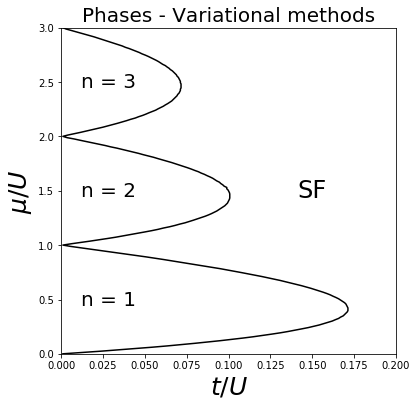

In [21]:
plt.figure(figsize=(6,6))
plt.plot(bd,mulist,color = 'black')
plt.title('Phases - Variational methods',fontsize = 20)
plt.xlabel('$t/U$',fontsize = 25)
plt.ylabel('$\mu /U$',fontsize = 25)
plt.xlim(0,0.2)
plt.ylim(np.min(mulist),np.max(mulist))

plt.text(0.15,3/2, 'SF', size=24, ha='center', va='center')
for n in range(1,4):
    plt.text(0.028, n-0.5, 'n = {}'.format(n), size=20, ha='center', va='center')

plt.show()

As we see, the phase diagram generated with the variational method exactly matches the result using exact diagonalization.

### Imaginary-time propagation

The final method that we will look it is known as imaginary-time propagation. As this model is studied in the context of zero-temperature bosons, the only states of interest will be the ones with the lowest energy, known as the ground states. Rather than diagonalizing the entire Hamiltonian operator, which would require constructing the entire spectral decomposition, I use a method called \textit{imaginary time propagation}, which allows one to independently compute the ground state by solving the Schrödinger equation in a transformed time coordinate. Such a method is often much more efficient than exact diagonalization, especially when the Hamiltonian must be diagonalized numerically.

The general solution to the Schrödinger equation (in dimensionless units)

\begin{equation*}
i \frac{\partial}{\partial t} | \psi(t) \rangle = \hat H | \psi(t) \rangle
\end{equation*}

for a time-independent Hamiltonian $\hat H$ is given by some superposition of stationary states 

\begin{equation} \label{eqn:Eexpand}
| \psi(t) \rangle = \sum_{n=0}^\infty c_n e^{-i E_n t} | E_n \rangle
\end{equation}

where $E_n$ and $\ket{E_n}$ are the eigenvalues and eigenvectors of the Hamiltonian operator respectively, and $\{ c_n \}$ is some collection of complex numbers *** \cite{Sakurai1994}. Assume without loss of generality that the energy eigenvalues are listed in increasing order, i.e. $E_0 \leq E_1 \leq E_2 \leq \cdots$. Defining the imaginary time variable 

\begin{equation} 
\tau \equiv i t,
\end{equation}

the expansion can be written as

\begin{equation*}
| \psi \left( -i \tau\right) \rangle = \sum_{n=0}^\infty c_n e^{- E_n \tau} | E_n \rangle = e^{- E_0 \tau}\left(c_0 | E_0 \rangle + \sum_{n=1}^\infty  c_n e^{- \left(E_n-E_0\right) \tau} | E_n \rangle \right).
\end{equation*}

Notice that as the imaginary time $\tau$ gets large, the coefficients of the higher energy states die off exponentially quickly, and we end up with something proportional to the ground state 

\begin{equation*}
| \psi \left( -i \tau \right) \rangle \propto | E_0 \rangle \qquad \text{as $\tau \to \infty$}.
\end{equation*}

Making the imaginary time substitution, to the Schrödinger equation, we see that the propagation of the state $|\psi \rangle$ in imaginary time is governed by the differential equation
\begin{equation}\label{eqn:SchrodingerTau}
\frac{\partial}{\partial \tau} |\psi \rangle = -\hat H |\psi \rangle.
\end{equation}

Thus, by making some initial guess $| \phi_0 \rangle$, we can obtain the ground state by integrating the Schrödinger equation forward in imaginary time. It is worth noting that the transformation to imaginary time explicitly makes the Schrödinger equation non-unitary, and so the ground state resulting from imaginary time propagation will need to be explicitly re-normalized at each time step.

The tools used to implement the imaginary time propagation algorithm can be found in the imag_time.py module. To integrate the imaginary-time Schrödinger equation, a 5th order Runge-Kutta routine is implemented, and the wavefunction is explicitely re-normalized at each step in the routine to make up for the exponentially decaying amplitudes.

In [ ]:
#Import module I wrote for imaginary time propagation
import imag_time

#Count number of local CPUs
NCPU = psutil.cpu_count()

#Define list of chemical potentials to search over
mulist = np.linspace(0.001,3.0,250)

#Need to include this if statement for some reason...
if __name__ == '__main__':        

    with Pool(NCPU) as p:
        
        #Compute boundary points using exact diagonalization
        bd = p.map(imag_time.bd, mulist)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(bd,mulist,color = 'black')
plt.title('Phases - Imaginary time propagation',fontsize = 20)
plt.xlabel('$t/U$',fontsize = 25)
plt.ylabel('$\mu /U$',fontsize = 25)
plt.xlim(0,0.2)
plt.ylim(np.min(mulist),np.max(mulist))

plt.text(0.15,3/2, 'SF', size=24, ha='center', va='center')
for n in range(1,4):
    plt.text(0.028, n-0.5, 'n = {}'.format(n), size=20, ha='center', va='center')

plt.show()

Once again, the phase diagram is consisten with both exact diagonalization and variational approaches, as well as with the literature studies of the Bose-Hubbard model.

### Algorithm comparison

Given that each of the methods studied have been reliable for simulating the Bose-Hubbard model, the real comparison of their performance comes down to computational speed. To compare each of the algorithms, I will record the time it takes to compute the phase boundary in the center of the first insulator lobe $\mu/U = 0.5$. Given that each of the use precisely the same boundary search algorithm (i.e. the one found in bdsearch.py), this seems like a fair comparison.

In [ ]:
exact_diag.bd(0.5)
variational.bd(0.5)
imag_time.bd(0.5)

As we see, the...

### Conclusion

In this report, we looked at three distinct methods for simulating the zero-temperature dynamics of the Bose-Hubbard model, an approximate model for bosons in an optical lattice potential. Within the mean-field approximation, each of these methods were able to reliably produce the Bose-Hubbard phase diagram, by probing for a continuous phase transition, and these diagrams were also consistent with previous studies of this model. In terms of speed, we saw...

### Bibliography

R. Landig, L. Hruby, N. Dogra, M. Landini, R. Mottl, T. Donner, and T. Esslinger, Nature **532**, 476 (2016)